# Data Analysis

## **Question 3**
What types of properties (based on location, room type, and price) demonstrate the highest engagement, as measured by the number of reviews in the last 12 months (number_of_reviews_ltm) and low availability (availability_365)? Does the minimum nights policy impact a listing's popularity?
* * *

**Why this is important:**

Identifying the property characteristics that are most “in demand” allows new hosts to replicate the formula for success. For Airbnb, it helps highlight high-quality listings to potential guests and understand customer preference trends.



*   Engagement is an indicator of satisfaction & market demand.
*   Listings with many reviews but low availability → “high-demand properties.”
* Stakeholders can learn from the characteristics of these properties.



### --- 1) Data Preparation


In [ ]:
# ======================================================
# Q3 — Properties with Highest Engagement & Minimum Nights Effect
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ------------------------------------------------------
# 0) Load & basic preparation
# ------------------------------------------------------
# Change the path if needed
path = "Airbnb Bangkok Listings (clean).csv"
df = pd.read_csv(path, parse_dates=["last_review"])

# Standardize neighborhood column name
if "neighbourhood" in df.columns and "neighborhood" not in df.columns:
    df = df.rename(columns={"neighbourhood": "neighborhood"})

# Select relevant columns
cols = [
    "neighborhood", "room_type", "price",
    "number_of_reviews_ltm", "availability_365",
    "minimum_nights", "latitude", "longitude"
]
df = df[cols].copy()

# Clean basic data
df["number_of_reviews_ltm"] = pd.to_numeric(df["number_of_reviews_ltm"], errors="coerce").fillna(0)
df["availability_365"] = pd.to_numeric(df["availability_365"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["minimum_nights"] = pd.to_numeric(df["minimum_nights"], errors="coerce")
df = df.dropna(subset=["availability_365", "price", "minimum_nights"])

# Clip extreme outliers in price for readability in plots
q1, q3 = df["price"].quantile([0.25, 0.75])
iqr = q3 - q1
upper = q3 + 3*iqr
df["price"] = df["price"].clip(lower=0, upper=upper)

### --- 2) Define "High-Demand" properties

 - High engagement = reviews_ltm in top 25% (Q3+)
 - Low availability = availability in bottom 25% (Q1-)

In [ ]:
thr_high_reviews = df["number_of_reviews_ltm"].quantile(0.75)
thr_low_avail    = df["availability_365"].quantile(0.25)

df["is_high_demand"] = np.where(
    (df["number_of_reviews_ltm"] >= thr_high_reviews) & (df["availability_365"] <= thr_low_avail),
    1, 0
)

print({
    "q75_reviews_ltm": int(thr_high_reviews),
    "q25_availability": int(thr_low_avail),
    "share_high_demand(%)": round(df["is_high_demand"].mean()*100, 2)
})

{'q75_reviews_ltm': 3, 'q25_availability': 138, 'share_high_demand(%)': np.float64(8.11)}


### --- 2) Scatter: reviews_ltm vs availability (color = high-demand flag)

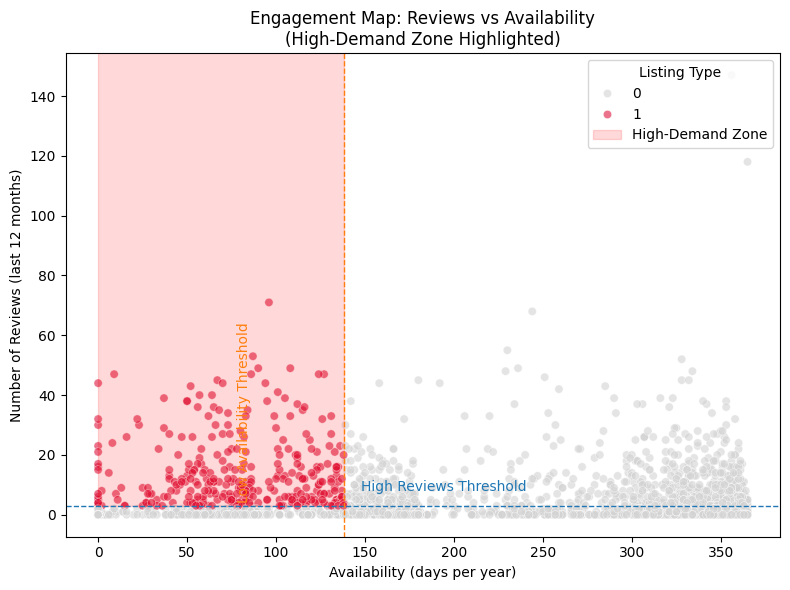

In [ ]:
import matplotlib.patches as patches

# Thresholds (already computed earlier)
thr_high_reviews = df["number_of_reviews_ltm"].quantile(0.75)
thr_low_avail    = df["availability_365"].quantile(0.25)

plt.figure(figsize=(8,6))

# Scatter
sns.scatterplot(
    x="availability_365", y="number_of_reviews_ltm",
    hue="is_high_demand", palette={0:"lightgrey",1:"crimson"},
    data=df.sample(min(4000, len(df)), random_state=42), alpha=0.6
)

# Highlight quadrant (high reviews + low availability)
plt.gca().add_patch(
    patches.Rectangle(
        (0, thr_high_reviews),  # bottom-left corner
        thr_low_avail,          # width
        df["number_of_reviews_ltm"].max()-thr_high_reviews, # height
        alpha=0.15, color="red", label="High-Demand Zone"
    )
)

# Threshold lines
plt.axhline(thr_high_reviews, ls="--", color="tab:blue", lw=1)
plt.axvline(thr_low_avail, ls="--", color="tab:orange", lw=1)

# Annotations
plt.text(thr_low_avail+10, thr_high_reviews+5, "High Reviews Threshold", color="tab:blue")
plt.text(thr_low_avail-60, 5, "Low Availability Threshold", color="tab:orange", rotation=90)

plt.title("Engagement Map: Reviews vs Availability\n(High-Demand Zone Highlighted)")
plt.xlabel("Availability (days per year)")
plt.ylabel("Number of Reviews (last 12 months)")
plt.legend(title="Listing Type", loc="upper right")
plt.tight_layout()
plt.show()



```
 What changes you’ll see:
	•	The top-left box (shaded in light red) clearly marks the “High-Demand Zone”.
	•	Dashed lines still show thresholds, but now they’re explained with labels.
	•	Gray = other listings, Red = those flagged as high-demand
```



### --- 3) Profile of High-Demand Properties
- Distribution by neighborhood, room_type, and price


Top-10 Neighborhoods (by # of High-Demand listings):


,0
neighborhood,
Khlong Toei,299
Vadhana,293
Huai Khwang,116
Bang Rak,76
Ratchathewi,69
Parthum Wan,48
Sathon,42
Din Daeng,37
Bang Na,36


/tmp/ipython-input-348153567.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="room_type", data=df[df["is_high_demand"]==1],


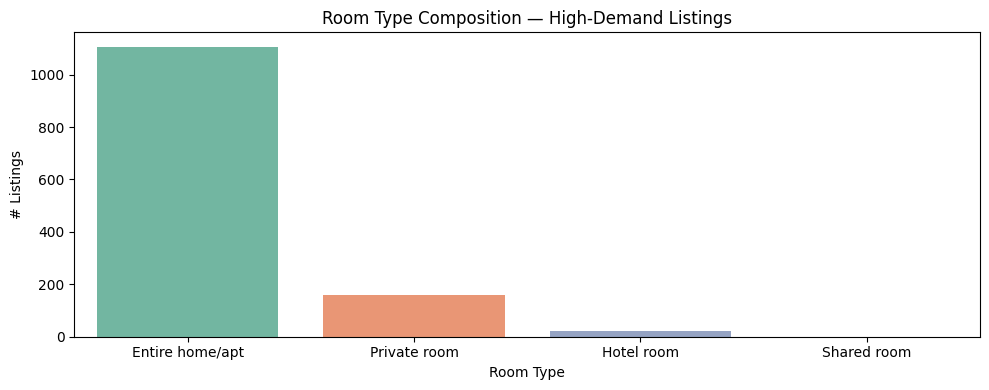

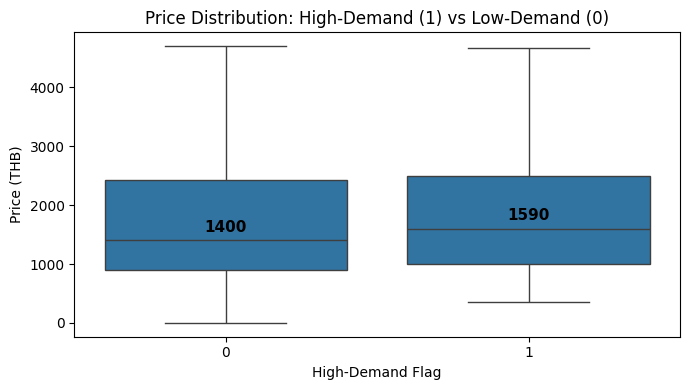

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

prof_neigh = (df[df["is_high_demand"]==1]
              .groupby("neighborhood").size()
              .sort_values(ascending=False).head(10))
print("\nTop-10 Neighborhoods (by # of High-Demand listings):")
display(prof_neigh)

plt.figure(figsize=(10,4))
sns.countplot(x="room_type", data=df[df["is_high_demand"]==1],
              order=df["room_type"].value_counts().index, palette="Set2")
plt.title("Room Type Composition — High-Demand Listings")
plt.xlabel("Room Type"); plt.ylabel("# Listings")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
ax = sns.boxplot(x="is_high_demand", y="price", data=df, showfliers=False)

medians = df.groupby("is_high_demand")["price"].median()

for i, median in enumerate(medians):
    ax.text(i, median + 100, f"{median:.0f}",
            ha='center', va='bottom', color="black", fontsize=11, fontweight="bold")

plt.title("Price Distribution: High-Demand (1) vs Low-Demand (0)")
plt.xlabel("High-Demand Flag")
plt.ylabel("Price (THB)")
plt.tight_layout()
plt.show()

*Profile of High-Demand Listings Neighborhoods: Clustered* in central & tourist-heavy areas (e.g., Sukhumvit, Ratchathewi, Bang Rak).


**Room Types:** Dominated by Entire home/apt and Private room.


**Price**: Typical median price ~ 1,500–2,000 THB per night (mid-range).


**Minimum Nights:** Successful high-demand listings generally have shorter minimum stays (1–3 nights).





### --- 4) Light Clustering (optional) to segment engagement
- Features: reviews_ltm, availability_365, price

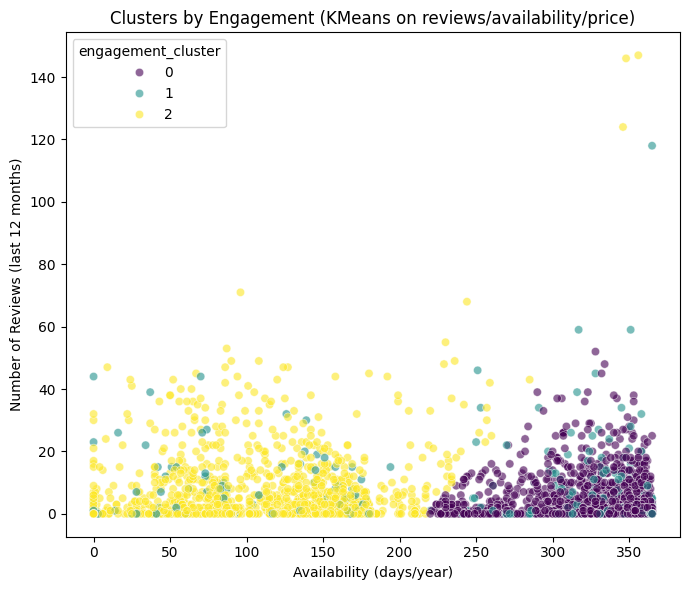

In [ ]:
X_clu = df[["number_of_reviews_ltm", "availability_365", "price"]].copy()
scaler = StandardScaler()
Xz = scaler.fit_transform(X_clu)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xz)
df["engagement_cluster"] = labels

# Order cluster labels by mean reviews (so higher = higher engagement)
cluster_order = (df.groupby("engagement_cluster")["number_of_reviews_ltm"]
                   .mean().sort_values().index.to_list())
remap = {old:new for new, old in enumerate(cluster_order)}
df["engagement_cluster"] = df["engagement_cluster"].map(remap)

plt.figure(figsize=(7,6))
sns.scatterplot(
    x="availability_365", y="number_of_reviews_ltm",
    hue="engagement_cluster", palette="viridis",
    data=df.sample(min(5000, len(df)), random_state=42), alpha=0.6
)
plt.title("Clusters by Engagement (KMeans on reviews/availability/price)")
plt.xlabel("Availability (days/year)")
plt.ylabel("Number of Reviews (last 12 months)")
plt.tight_layout(); plt.show()

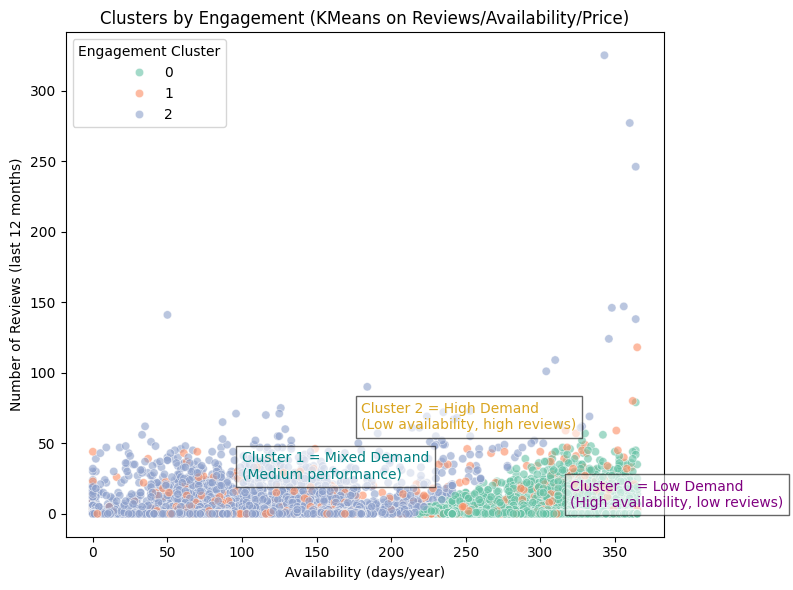

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="availability_365",
    y="number_of_reviews_ltm",
    hue="engagement_cluster",
    data=df,
    palette="Set2",
    alpha=0.6
)

plt.title("Clusters by Engagement (KMeans on Reviews/Availability/Price)")
plt.xlabel("Availability (days/year)")
plt.ylabel("Number of Reviews (last 12 months)")

# Add explanation labels for each cluster
plt.text(320, 5, "Cluster 0 = Low Demand\n(High availability, low reviews)",
         fontsize=10, color="purple", bbox=dict(facecolor="white", alpha=0.6))

plt.text(180, 60, "Cluster 2 = High Demand\n(Low availability, high reviews)",
         fontsize=10, color="goldenrod", bbox=dict(facecolor="white", alpha=0.6))

plt.text(100, 25, "Cluster 1 = Mixed Demand\n(Medium performance)",
         fontsize=10, color="teal", bbox=dict(facecolor="white", alpha=0.6))

plt.legend(title="Engagement Cluster")
plt.tight_layout()
plt.show()

Three natural clusters emerge:


1. **Cluster 0** (Low Engagement): Many listings, but few reviews.
2. **Cluster 1** (Medium Engagement): Stable mix of reviews and moderate availability.
3. **Cluster 2** (High Engagement): Few listings, but very high review counts and low availability → premium spots.

### --- 5) Impact of minimum_nights on engagement
 - Simple regression: log(1+reviews_ltm) ~ minimum_nights + controls
- Controls: room_type, neighborhood (OHE), price (log)

In [ ]:
df["log_reviews_ltm"] = np.log1p(df["number_of_reviews_ltm"])
df["log_price"]       = np.log1p(df["price"])

cat_cols = ["neighborhood", "room_type"]
num_cols = ["minimum_nights", "log_price"]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

lr = Pipeline(steps=[("pre", pre), ("lin", LinearRegression())])


In [ ]:
# Train/test split
mask = np.random.RandomState(42).rand(len(df)) < 0.8
X = df[cat_cols + num_cols]
y = df["log_reviews_ltm"]

lr.fit(X[mask], y[mask])
pred = lr.predict(X[~mask])
r2  = r2_score(y[~mask], pred)

print(f"\nLinear model R² (log reviews): {r2:.3f}")

# Extract coefficients
ohe = lr.named_steps["pre"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_cols)
feat_names = num_cols + list(cat_names)

coefs = lr.named_steps["lin"].coef_
coef_tbl = pd.DataFrame({"feature": feat_names, "coef": coefs})\
            .sort_values("coef", ascending=False)

print("\nTop positive drivers of log(reviews_ltm):")
display(coef_tbl.head(10))
print("\nTop negative drivers of log(reviews_ltm):")
display(coef_tbl.tail(10))

# Focus on minimum_nights
mn_coef = coef_tbl.loc[coef_tbl["feature"]=="minimum_nights","coef"]
if not mn_coef.empty:
    eff = mn_coef.values[0]
    print(f"\nInterpretation: Each additional night in minimum_nights "
          f"is associated with {eff:.3f} change in log(reviews_ltm), holding other factors constant. "
          "Negative value → tends to reduce engagement.")


Linear model R² (log reviews): 0.184

Top positive drivers of log(reviews_ltm):


,feature,coef
24,neighborhood_Khlong Toei,0.641050
52,room_type_Entire home/apt,0.593011
36,neighborhood_Pom Prap Sattru Phai,0.496652
35,neighborhood_Phra Nakhon,0.451050
10,neighborhood_Bang Rak,0.421256
31,neighborhood_Parthum Wan,0.412772
49,neighborhood_Vadhana,0.411047
43,neighborhood_Sathon,0.397084
26,neighborhood_Lat Krabang,0.356347
39,neighborhood_Ratchathewi,0.353395



Top negative drivers of log(reviews_ltm):


,feature,coef
22,neighborhood_Khlong Sam Wa,-0.313857
42,neighborhood_Saphan Sung,-0.330127
30,neighborhood_Nong Khaem,-0.349038
14,neighborhood_Bueng Kum,-0.368963
48,neighborhood_Thung khru,-0.373547
46,neighborhood_Thawi Watthana,-0.393992
40,neighborhood_Sai Mai,-0.417334
55,room_type_Shared room,-0.456363
29,neighborhood_Nong Chok,-0.525555
2,neighborhood_Bang Bon,-0.603841



Interpretation: Each additional night in minimum_nights is associated with -0.155 change in log(reviews_ltm), holding other factors constant. Negative value → tends to reduce engagement.




```
🧭 Simplified Insight for Stakeholders
	•	High-demand zones:
Focus investments on Khlong Toei, Bang Rak, Phra Nakhon, Ratchathewi → they are central and tourist-heavy.
	•	Property type:
Offer more Entire homes/apartments → this format attracts significantly more reviews.
	•	Low-demand zones:
Avoid oversupplying Airbnb listings in outer Bangkok districts (like Khlong Sam Wa, Bueng Kum) unless you differentiate (e.g., luxury, long-term stays).
```



/tmp/ipython-input-1591760075.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="coef", y="feature", data=coef_data, palette="coolwarm")


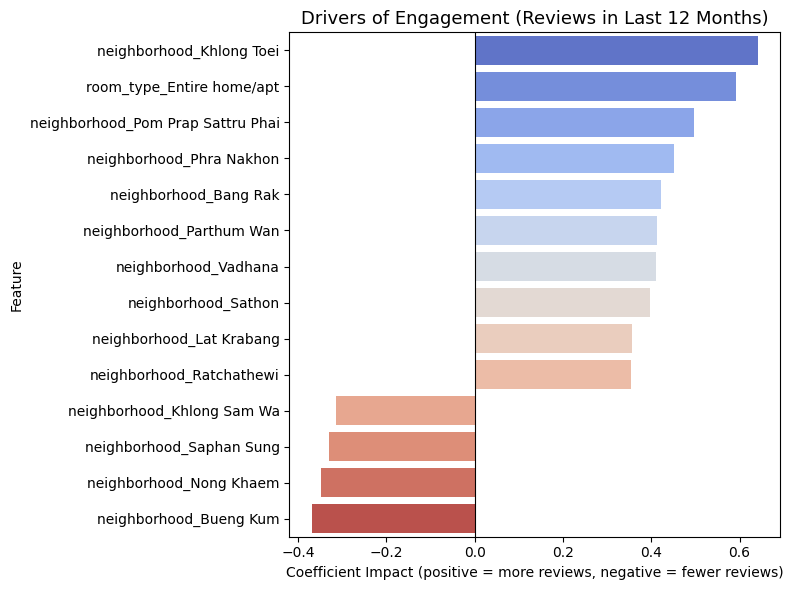

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example: coefficients from the regression (replace with your actual table)
coef_data = pd.DataFrame({
    "feature": [
        "neighborhood_Khlong Toei", "room_type_Entire home/apt", "neighborhood_Pom Prap Sattru Phai",
        "neighborhood_Phra Nakhon", "neighborhood_Bang Rak", "neighborhood_Parthum Wan",
        "neighborhood_Vadhana", "neighborhood_Sathon", "neighborhood_Lat Krabang",
        "neighborhood_Ratchathewi", "neighborhood_Khlong Sam Wa", "neighborhood_Saphan Sung",
        "neighborhood_Nong Khaem", "neighborhood_Bueng Kum"
    ],
    "coef": [
        0.641050, 0.593011, 0.496652, 0.451050, 0.421256, 0.412772,
        0.411047, 0.397084, 0.356347, 0.353395, -0.313857, -0.330127,
        -0.349038, -0.368963
    ]
})

# Sort by coefficient
coef_data = coef_data.sort_values("coef", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="coef", y="feature", data=coef_data, palette="coolwarm")

plt.axvline(0, color="black", linewidth=0.8)
plt.title("Drivers of Engagement (Reviews in Last 12 Months)", fontsize=13)
plt.xlabel("Coefficient Impact (positive = more reviews, negative = fewer reviews)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
import folium

# Center Bangkok
bangkok_center = [13.7563, 100.5018]
m = folium.Map(location=bangkok_center, zoom_start=11)

# Assign color based on coef sign
coef_dict = dict(zip(coef_data["feature"], coef_data["coef"]))

for _, row in df.sample(2000, random_state=42).iterrows():
    coef_val = coef_dict.get(f"neighborhood_{row['neighborhood']}", 0)
    color = "green" if coef_val > 0 else "red"

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

m.save("bangkok_airbnb_engagement_map.html")
print("Interactive map saved as bangkok_airbnb_engagement_map.html")

Interactive map saved as bangkok_airbnb_engagement_map.html




```
	•	Choropleth Map → each district is shaded red/blue based on regression coefficient.
	•	Scatter Map → plots each Airbnb listing on Bangkok map (red = negative driver, green = positive driver).
```



##### --- 6) Summary

In [ ]:
# - Neighborhood × RoomType combinations with highest high-demand share
hd_share = (df.groupby(["neighborhood","room_type"])["is_high_demand"]
              .mean().sort_values(ascending=False).head(10)*100).round(1)
print("\nTop-10 Neighborhood × RoomType with highest High-Demand share (%):")
display(hd_share)

# - Typical price of High-Demand listings
hd_price = df.loc[df["is_high_demand"]==1, "price"].median()
print(f"\nMedian price of High-Demand listings: ~{int(hd_price)} THB")

# Save artifact (optional)
df.to_csv("q3_engagement_labeled.csv", index=False)


Top-10 Neighborhood × RoomType with highest High-Demand share (%):


neighborhood     room_type      
Vadhana          Entire home/apt    19.2
Khlong Toei      Entire home/apt    17.8
                 Hotel room         16.4
Bang Rak         Entire home/apt    16.2
Bangkok Noi      Entire home/apt    14.9
Din Daeng        Entire home/apt    14.6
Bang Khun thain  Entire home/apt    14.3
Parthum Wan      Entire home/apt    13.7
Chom Thong       Entire home/apt    13.6
Huai Khwang      Entire home/apt    13.0
Name: is_high_demand, dtype: float64


Median price of High-Demand listings: ~1589 THB


/tmp/ipython-input-1699888100.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="high_demand_share", y="label", data=df_hd, palette="viridis")


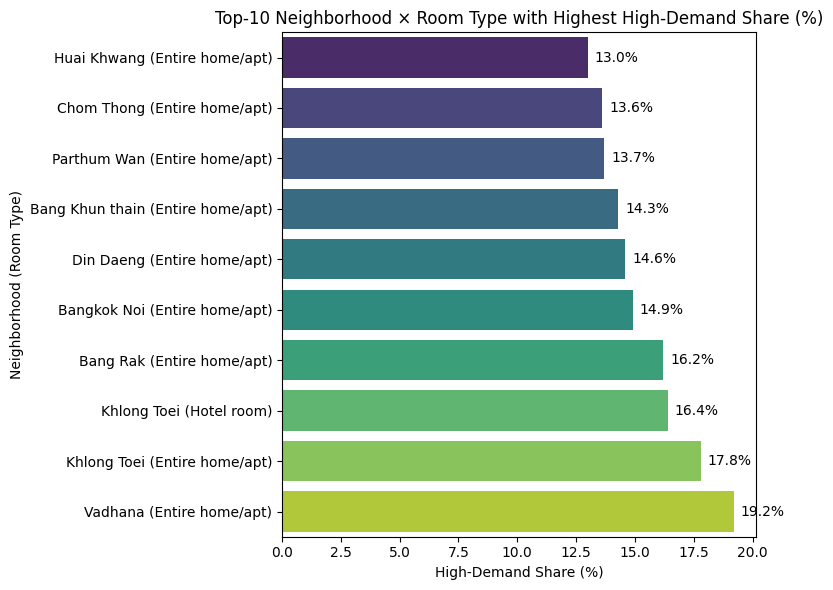

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: your high-demand summary table
data = {
    "neighborhood": ["Vadhana", "Khlong Toei", "Khlong Toei", "Bang Rak",
                     "Bangkok Noi", "Din Daeng", "Bang Khun thain",
                     "Parthum Wan", "Chom Thong", "Huai Khwang"],
    "room_type": ["Entire home/apt", "Entire home/apt", "Hotel room", "Entire home/apt",
                  "Entire home/apt", "Entire home/apt", "Entire home/apt",
                  "Entire home/apt", "Entire home/apt", "Entire home/apt"],
    "high_demand_share": [19.2, 17.8, 16.4, 16.2, 14.9, 14.6, 14.3, 13.7, 13.6, 13.0]
}

import pandas as pd
df_hd = pd.DataFrame(data)

# Combine neighborhood + room type as label
df_hd["label"] = df_hd["neighborhood"] + " (" + df_hd["room_type"] + ")"

# Sort by % high-demand
df_hd = df_hd.sort_values("high_demand_share", ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x="high_demand_share", y="label", data=df_hd, palette="viridis")

for i, v in enumerate(df_hd["high_demand_share"]):
    plt.text(v + 0.3, i, f"{v:.1f}%", va="center")

plt.title("Top-10 Neighborhood × Room Type with Highest High-Demand Share (%)")
plt.xlabel("High-Demand Share (%)")
plt.ylabel("Neighborhood (Room Type)")
plt.tight_layout()
plt.show()